In [133]:
import torch
import torch.optim as optim
from models.attention import Attention
from matplotlib import pyplot as plt
from utils.helper import make_beta_schedule, EMA
from utils.plots import hdr_plot_style
hdr_plot_style()
from tqdm import tqdm
from ddpm import DDPM1d


In [134]:
device = torch.device("cuda:2") if torch.cuda.is_available() else "cpu"

In [135]:
device

device(type='cuda', index=2)

# Dataset

In [136]:
loads = torch.load("./data/London/processed/energy_block_0.pt")
# dataset = loads.reshape(-1, loads.shape[-1])
loads.shape

torch.Size([50, 819, 48])

In [137]:
loads[0]

tensor([[0.2525, 0.0000, 0.0000,  ..., 0.3250, 0.2690, 0.2900],
        [0.2630, 0.2690, 0.2750,  ..., 0.1880, 0.2590, 0.2500],
        [0.2620, 0.1660, 0.2260,  ..., 0.2100, 0.2780, 0.1590],
        ...,
        [0.2525, 0.2525, 0.2525,  ..., 0.2525, 0.2525, 0.2525],
        [0.2525, 0.2525, 0.2525,  ..., 0.2525, 0.2525, 0.2525],
        [0.2525, 0.2525, 0.2525,  ..., 0.2525, 0.2525, 0.2525]])

Text(0.5, 1.0, 'variance')

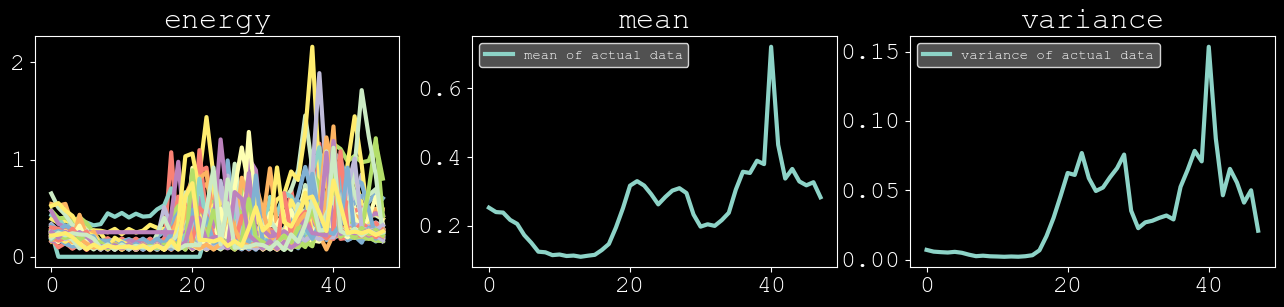

In [138]:
dataset = loads[0][:100]
plt.figure(figsize=(16,3))
plt.subplot(1,3,1)
for i in range(50):
    plt.plot(dataset[i])
plt.title("energy")

plt.subplot(1,3,2)
plt.plot(dataset.mean(dim=0), label = "mean of actual data")
plt.legend(fontsize=10)
plt.title("mean")
plt.subplot(1,3,3)
plt.plot(dataset.var(dim=0), label = "variance of actual data")
plt.legend(fontsize=10)
plt.title("variance")

In [139]:
dataset.shape

torch.Size([100, 48])

In [140]:
dataset = dataset/(dataset.max() - dataset.min()) * 2
dataset = dataset - (dataset.max() + dataset.min())/2
# mean = dataset.mean()
# var = dataset.var()

# dataset = (dataset - mean) 
dataset.mean(), dataset.var(), dataset.min(), dataset.max()

(tensor(-0.7657), tensor(0.0410), tensor(-1.), tensor(1.))

In [141]:
# Select betas
n_steps = 500
input_dim = 48
betas = make_beta_schedule(schedule='linear', n_timesteps=n_steps, start=1e-6, end=5e-2)
betas = betas.to(device)
model = Attention(input_dim, 512)
# model = ConditionalUNet1D(96, 16)
model = model.to(device)
dataset = dataset.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
ddpm = DDPM1d(model, betas, n_steps, (input_dim,), loss_type='l2')


# Create EMA model
ema = EMA(0.9)
ema.register(model)
epoch = 8000
batch_size = 1024
Loss = []
for j in tqdm(range(epoch)):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch 
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]
        # Compute the loss.
        loss = ddpm(batch_x)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
        # Update the exponential moving average
        ema.update(model)
        ddpm.model = model
    if j % 50 == 0:
        Loss.append(loss.item())
    if j%1000 == 0:
        print("loss: ", loss.item())
        torch.save(model, "./result/model_grid.pth")

/home/npg5/anaconda3/envs/hnn/lib/python3.8/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
  0%|          | 9/8000 [00:00<01:29, 89.58it/s]

  0%|          | 23/8000 [00:00<01:08, 115.82it/s]

loss:  1.0505117177963257


 13%|█▎        | 1010/8000 [00:09<01:11, 98.41it/s]

loss:  0.08619727939367294


 25%|██▌       | 2018/8000 [00:19<00:55, 107.23it/s]

loss:  0.10755373537540436


 38%|███▊      | 3018/8000 [00:28<00:46, 107.01it/s]

loss:  0.11109113693237305


 50%|█████     | 4015/8000 [00:37<00:37, 105.91it/s]

loss:  0.06691762804985046


 63%|██████▎   | 5015/8000 [00:47<00:28, 105.61it/s]

loss:  0.08166284114122391


 75%|███████▌  | 6011/8000 [00:56<00:20, 99.25it/s] 

loss:  0.0968572124838829


 88%|████████▊ | 7019/8000 [01:06<00:09, 107.36it/s]

loss:  0.07476626336574554


100%|██████████| 8000/8000 [01:15<00:00, 105.68it/s]


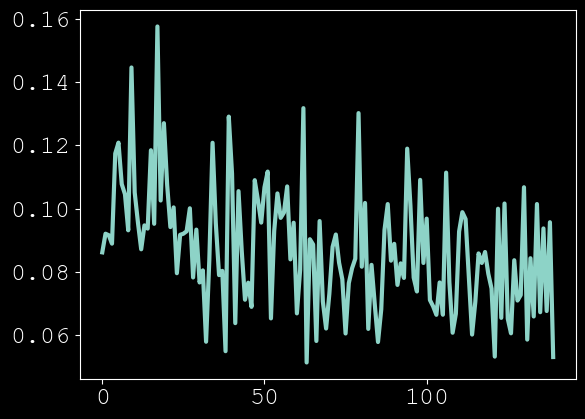

In [142]:
plt.plot(Loss[20:])

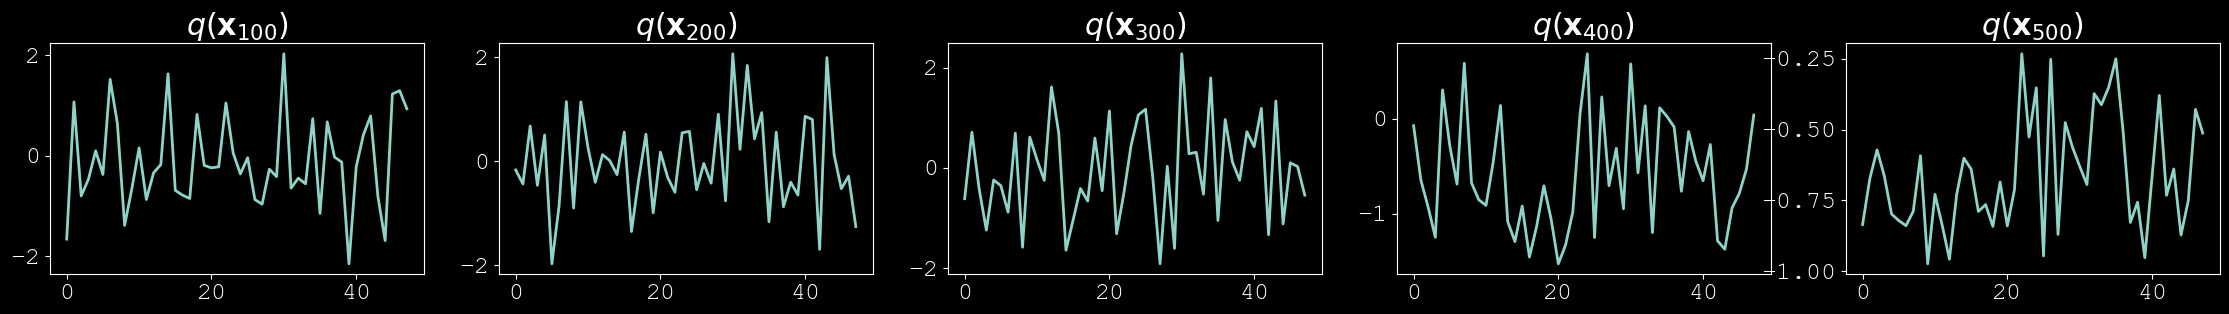

In [143]:
x_seq = ddpm.sample_seq(batch_size=100)
interval = int(len(x_seq)/5)
x_seq = x_seq.to("cpu")
fig, axs = plt.subplots(1, 5, figsize=(28, 3))
for i in range(1, 6):
    cur_x = x_seq[i * interval - 1]
    axs[i-1].plot(cur_x[1, :], linewidth=2);
    #axs[i].set_axis_off(); 
    axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*interval)+'})$')

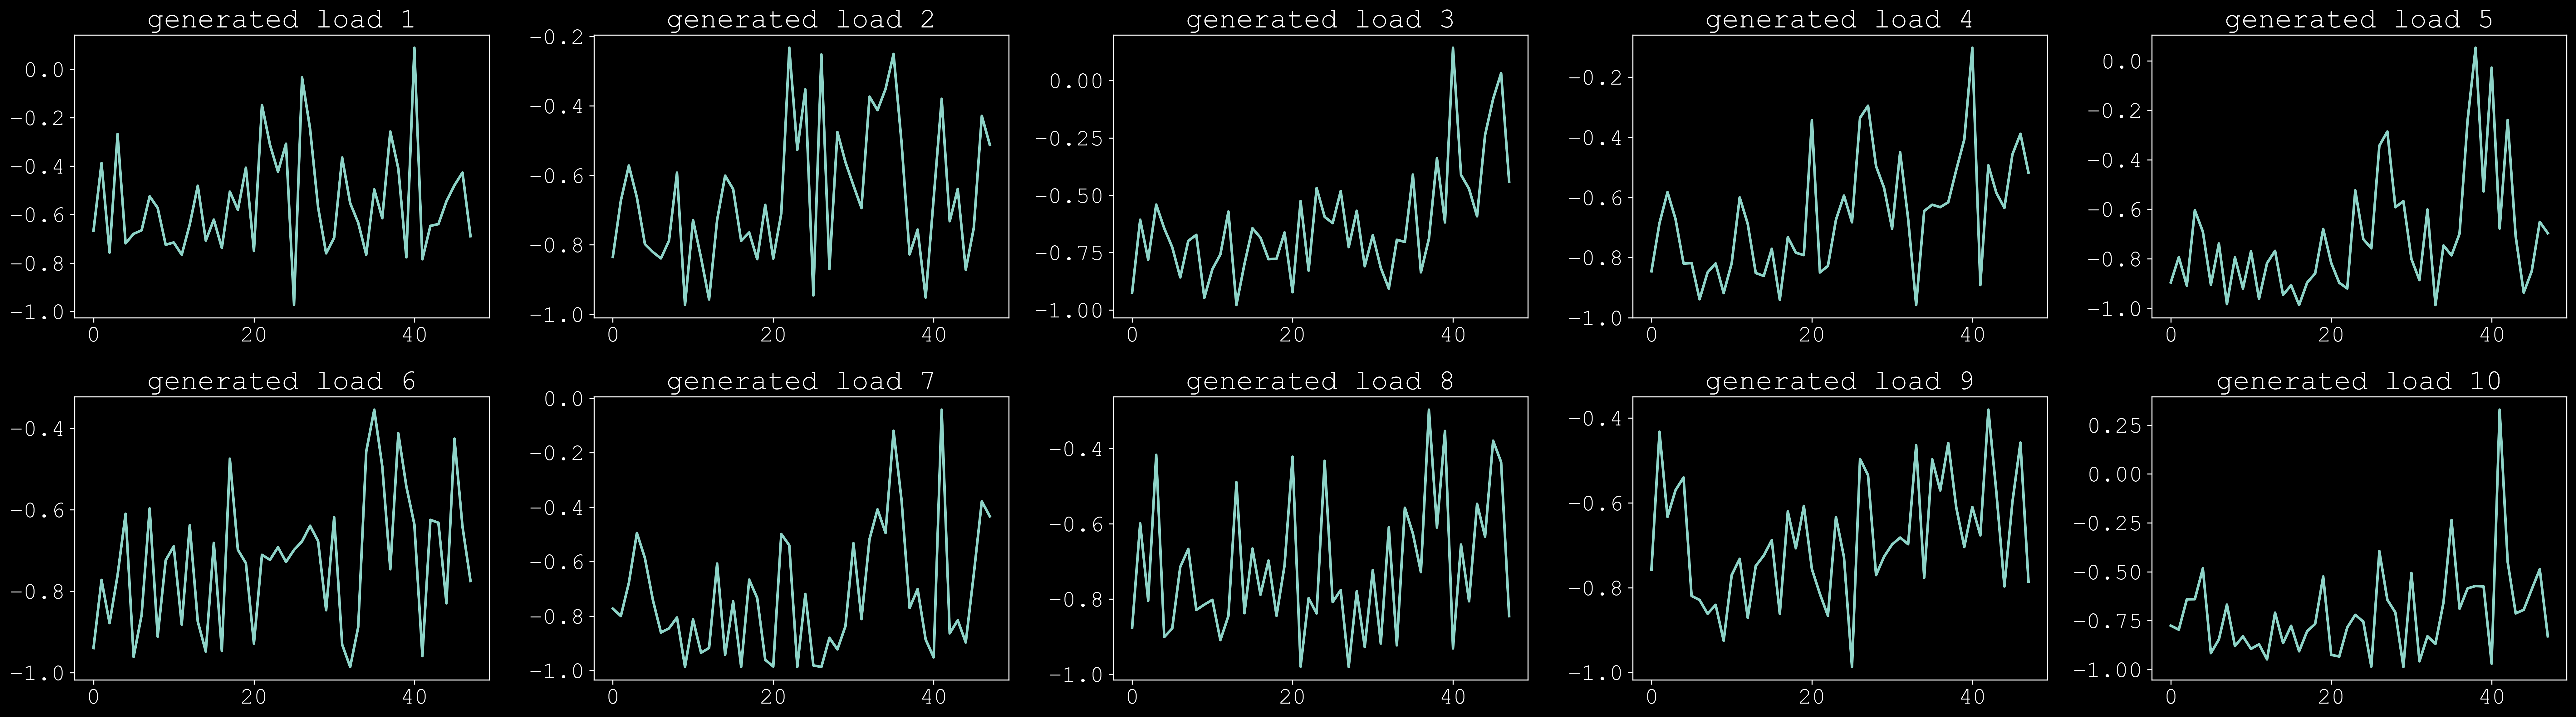

In [144]:
fig, axs = plt.subplots(2, 5, figsize=(28, 8), dpi=300)
for i in range(5):
    cur_x = x_seq[-1]
    axs[0, i].plot(cur_x[i, :], linewidth=2);
    axs[1, i].plot(cur_x[i+5, :], linewidth=2);
    axs[0, i].set_title('generated load {}'.format(i+1))
    axs[1, i].set_title('generated load {}'.format(i+6))
    #axs[i].set_axis_off(); 
plt.tight_layout()

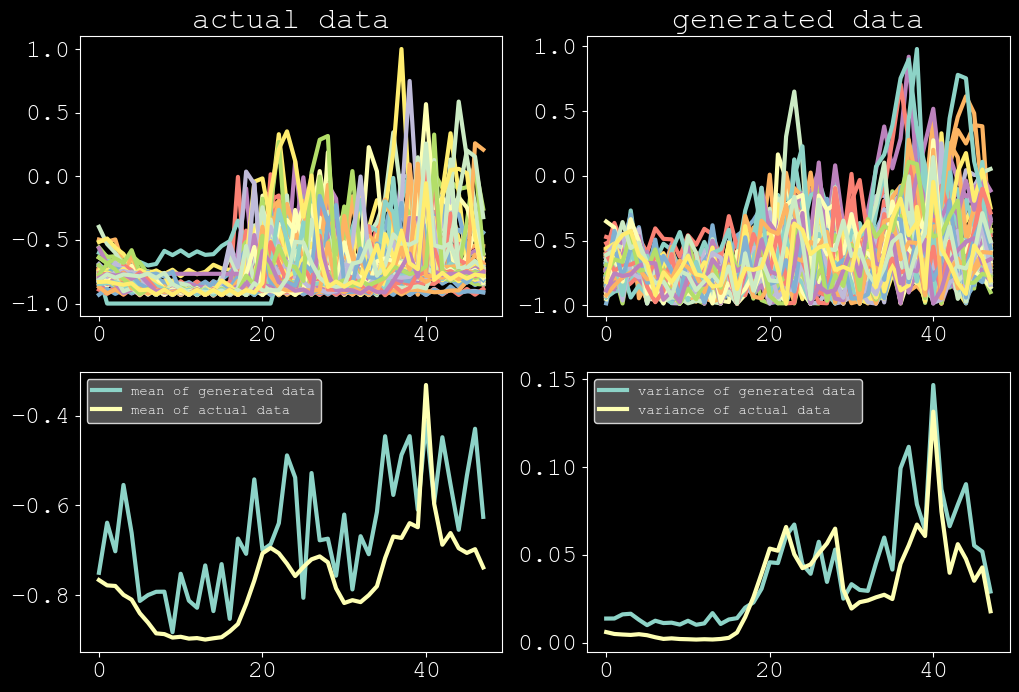

In [145]:
dataset = dataset.to('cpu')
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
for i in range(len(dataset)):
    plt.plot(dataset[i])
plt.title("actual data")
plt.subplot(2,2,2)
for i in range(len(x_seq[-1])):
    plt.plot(x_seq[-1][i])
plt.title("generated data")
plt.subplot(2,2,3)
plt.plot(x_seq[-1].mean(dim=0), label = "mean of generated data")
plt.plot(dataset.mean(dim=0), label = "mean of actual data")
plt.legend(fontsize=10)
plt.subplot(2,2,4)
plt.plot(x_seq[-1].var(dim=0), label = "variance of generated data")
plt.plot(dataset.var(dim=0), label = "variance of actual data")
plt.legend(fontsize=10)